```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if (p.endswith("gpuocean/src") or p.endswith("gpuocean\\src"))][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 9e2194949a236a78754252e0e34f69f9b1e1823f on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

import datetime

#For plotting
import matplotlib
from matplotlib import pyplot as plt

# plt.rcParams["lines.color"] = "w"
# plt.rcParams["text.color"] = "w"
# plt.rcParams["axes.labelcolor"] = "w"
# plt.rcParams["xtick.color"] = "w"
# plt.rcParams["ytick.color"] = "w"

# plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [4]:
%cuda_context_handler gpu_ctx

Path to the test file

In [5]:
source_url = "/lustre/storeB/project/fou/hi/NorFjords160/A12/norfjords_160m_his.nc4_2020020101-2020020200"
# source_url = "/sintef/data/NorFjords160/A11/norfjords_160m_his.nc4_2020020101-2020020200"

## Inspecting file structure and content

In [6]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:      (eta_rho: 1271, eta_u: 1271, eta_v: 1270, ocean_time: 24, s_rho: 35, s_w: 36, xi_rho: 2051, xi_u: 2050, xi_v: 2051)
Coordinates:
  * ocean_time   (ocean_time) datetime64[ns] 2020-02-01T01:00:00 ... 2020-02-02
  * s_rho        (s_rho) float64 -0.9857 -0.9571 -0.9286 ... -0.04286 -0.01429
  * s_w          (s_w) float64 -1.0 -0.9714 -0.9429 ... -0.05714 -0.02857 0.0
    lon_rho      (eta_rho, xi_rho) float64 ...
    lat_rho      (eta_rho, xi_rho) float64 ...
    lon_u        (eta_u, xi_u) float64 ...
    lat_u        (eta_u, xi_u) float64 ...
    lon_v        (eta_v, xi_v) float64 ...
    lat_v        (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, eta_u, eta_v, xi_rho, xi_u, xi_v
Data variables: (12/32)
    Vtransform   int32 ...
    Vstretching  int32 ...
    theta_s      float64 ...
    theta_b      float64 ...
    Tcline       float64 ...
    hc           float64 ...
    ...           ...
    u            (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v            (ocean_time, s_rho, eta_v, xi_v) float32 ...
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    AKt          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
    AKs          (ocean_time, s_w, eta_rho, xi_rho) float32 ...
Attributes:
    history:      Created by roms2nc4single.py from ROMS output file
    institution:  Institute of Marine Research
    type:         ROMS/TOMS history file
    title:        ROMS 3.5 - NorFjords
    svn_url:      https://www.myroms.org/svn/omlab/branches/kate
    code_dir:     /cluster/work/users/jonal/NorROMS/ROMS_src/official/ROMS_kate
    CPP_options:  NORFJORDS, ALBEDO, ATM_PRESS, ANA_BSFLUX, ANA_BTFLUX, ANA_S...

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  # Remove the CWD from sys.path while we load stuff.


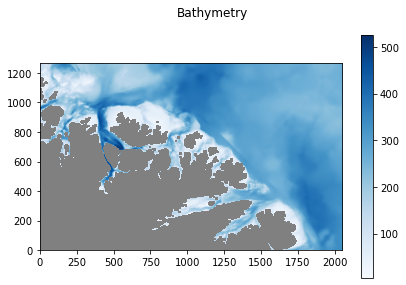

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

H_m = np.ma.array(nc["h"][1:-1,1:-1], mask=(1-nc["mask_rho"][1:-1,1:-1]))

fig, ax = plt.subplots()
fig.suptitle("Bathymetry")

cmap = plt.cm.Blues
cmap.set_bad("grey", alpha = 1.0)
im = ax.imshow(H_m, cmap=cmap, origin="lower")

plt.colorbar(im, ax=ax)
plt.tight_layout()

## Generating GPUOcean Simulation from Input

In [8]:
dimY, dimX = ds.h.data.shape

In [9]:
x0, x1, y0, y1 = 1100, dimX-350, 5, dimY-400

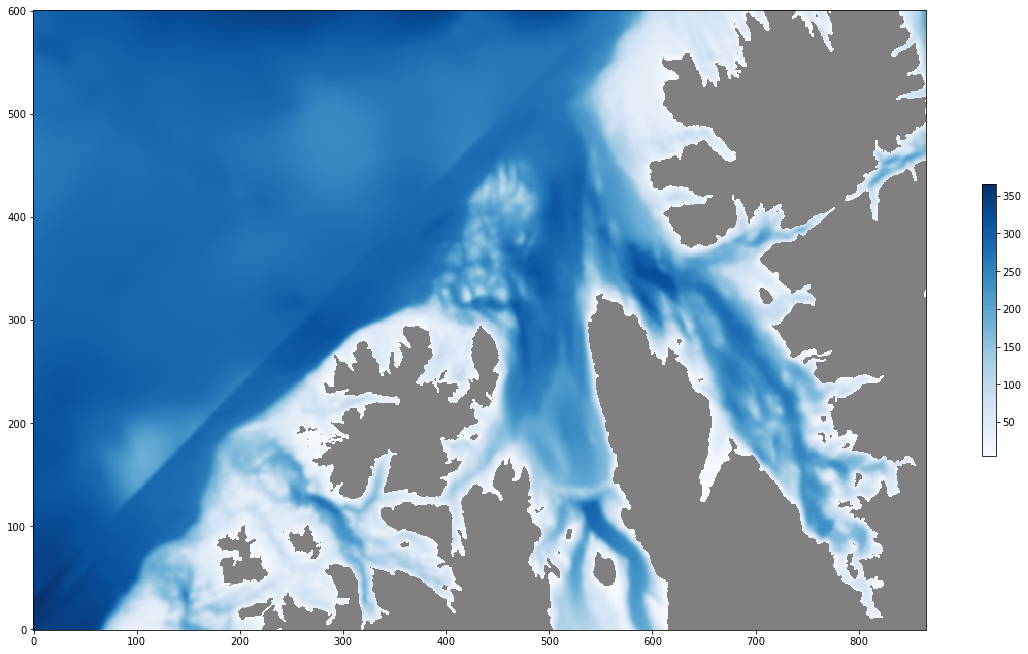

In [10]:
fig, ax = plt.subplots(figsize=(20,20))
im= ax.imshow(np.flip(np.ma.array(nc["h"][y0:y1, x0:x1], mask = 1-nc["mask_rho"][y0:y1,x0:x1]), axis=0).T, interpolation="none", cmap="Blues", origin="lower")
plt.colorbar(im, shrink=0.25)

In [11]:
nc.variables.keys()

dict_keys(['ocean_time', 'Vtransform', 'Vstretching', 'theta_s', 'theta_b', 'Tcline', 'hc', 's_rho', 's_w', 'Cs_r', 'Cs_w', 'h', 'mask_rho', 'mask_u', 'mask_v', 'angle', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'aice', 'hice', 'snow_thick', 'uice', 'vice', 'zeta', 'ubar', 'vbar', 'Uwind', 'Vwind', 'swrad', 'u', 'v', 'temp', 'salt', 'AKt', 'AKs'])

In [12]:
nx = (x1-x0)-4
ny = (y1-y0)-4

NX = nx+4
NY = ny+4

dx = 160.0
dy = 160.0

Check Mixed-Layer Depth

In [13]:
t=12

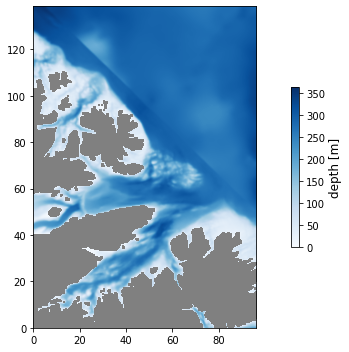

In [31]:
cmap = copy.copy(plt.cm.Blues)
cmap.set_bad("grey", alpha = 1.0)

domain_extent = [0, (x1-x0)*160/1000, 0, (y1-y0)*160/1000]

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    
    fig, ax = plt.subplots(figsize=(10,5))
    
    im = ax.imshow(np.ma.array(nc["h"][y0:y1,x0:x1], mask=(1-nc["mask_rho"][y0:y1,x0:x1])), 
                   vmin=0, origin="lower",
                   cmap=cmap, extent=domain_extent)
    
    cb = plt.colorbar(im, ax=ax, shrink=0.5)
    cb.set_label(label="depth [m]", size=12)
    plt.tight_layout()



Check densities

In [15]:
y_cut = 450

2042-02-01 11:00:00


/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Oranges"))


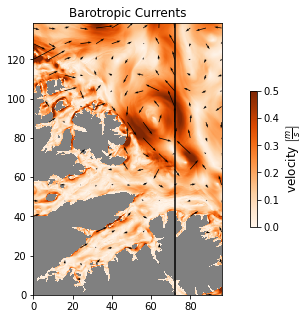

In [48]:
# x0, x1 = 2, dimX-2
# y0, y1 = 2, dimY-2
t = 10

H_m = nc["h"][y0:y1,x0:x1]

bt_u = 0.5*(nc["ubar"][t,y0:y1,x0:x1]+nc["ubar"][t,y0:y1,x0+1:x1+1])
bt_v = 0.5*(nc["vbar"][t,y0:y1,x0:x1]+nc["vbar"][t,y0+1:y1+1,x0:x1])

bt_velocity = np.sqrt(bt_u*bt_u + bt_v*bt_v)

ny, nx = bt_velocity.shape
dx, dy = 0.160, 0.160
domain_extent = [0, nx*dx, 0, ny*dy]

frequency_x = 50
frequency_y = 50
x = np.arange(0, bt_velocity.shape[1], frequency_x)*dx
y = np.arange(0, bt_velocity.shape[0], frequency_y)*dy
bt_qu = bt_u[::frequency_y, ::frequency_x]
bt_qv = bt_v[::frequency_y, ::frequency_x]


# ----------------------------

with plt.rc_context({'lines.color':'black', 
                        'text.color':'black', 
                        'axes.labelcolor':'black', 
                        'xtick.color':'black',
                        'ytick.color':'black'}):
    fig, ax = plt.subplots(figsize=(10,5))

    # ax.tick_params(colors='black')
    ax.xaxis.label.set_color('black')

    velo_cmap = plt.cm.Oranges
    velo_cmap.set_bad("grey", alpha = 1.0)

    im = ax.imshow(bt_velocity, interpolation="none", origin='lower', 
                        cmap=velo_cmap,
                        vmin=0, vmax=0.5,
                        extent=domain_extent)
    ax.quiver(x,y,bt_qu,bt_qv, scale=5)

    cb = plt.colorbar(im, ax=ax, shrink=0.5)
    cb.set_label(label="velocity $\left[ \\frac{m}{s} \\right]$", size=12)
    
    ax.axvline(x=y_cut*dx, c="black")
    
    ax.set_title("Barotropic Currents")
    

print(str(datetime.datetime.utcfromtimestamp(nc["ocean_time"][t]).strftime('%Y-%m-%d %H:%M:%S')))


In [93]:
s_pot_densities = NetCDFInitialization.potentialDensities(source_url, t=t, x0=x0, x1=x1, y0=y0, y1=y1)

s_nc = Dataset(source_url)
s_hs   = s_nc["h"][y0:y1,x0:x1]
s_rhos = s_nc["Cs_r"][:]

depth_show_meters = 300 # upper layer thickness for plotting in meters

depth_show_resolution = 1 # discretisation levels per meter

s_pot_densities_show = np.ma.array(np.zeros((s_pot_densities.shape[1],depth_show_meters*depth_show_resolution)))
s_pot_densities_show[:,0] =  s_pot_densities[-1][:,y_cut]
for depth_level in range(1,depth_show_resolution*depth_show_meters):
    depth = depth_level/depth_show_resolution

    integrator_low = NetCDFInitialization.MLD_integrator(source_url, np.ma.array(depth*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
    dens_low = np.sum(integrator_low * s_pot_densities, axis=0)
    if depth_level == 1:
        dens_up = 0.0
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        mask_next_level = copy.copy(s_pot_densities_show[:,depth_level]<1000)
    else:
        integrator_up = NetCDFInitialization.MLD_integrator(source_url, np.ma.array((depth-1/depth_show_resolution)*np.ones_like(H_m),mask=False), t=t, x0=x0, x1=x1, y0=y0, y1=y1)
        dens_up  = np.sum(integrator_up * s_pot_densities, axis=0)
        s_pot_densities_show[:,depth_level] =  (dens_low - dens_up)[:,y_cut]*depth_show_resolution
        s_pot_densities_show[:,depth_level].mask = copy.copy(mask_next_level)
        if depth > 5:
            mask_next_level = np.all((integrator_low[1:,:,y_cut] == integrator_up[1:,:,y_cut]), axis=0)

KeyboardInterrupt: 

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("YlOrRd_r"))
  after removing the cwd from sys.path.


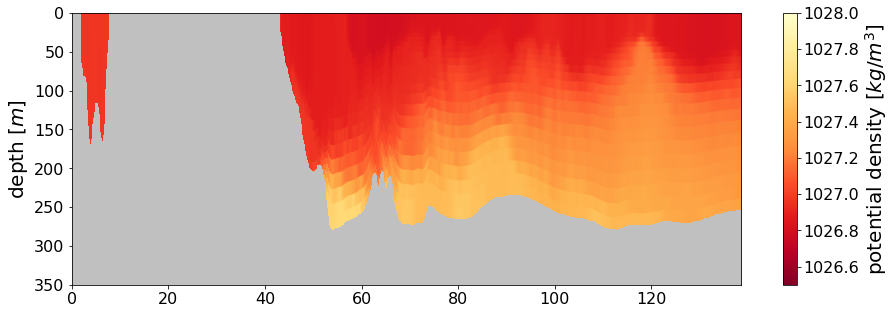

In [54]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap_dens = plt.cm.YlOrRd_r
cmap_dens.set_bad(alpha=0.25)

extent = [0, s_pot_densities_show.shape[0]*160/1000, depth_show_meters, 0]

im = ax.imshow(s_pot_densities_show.T, 
                origin="upper", cmap=cmap_dens, 
                aspect='auto', extent=extent, 
                vmin=1026.5, vmax=1028)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("depth [$m$]", fontsize=20)

cb = plt.colorbar(im, pad=0.05)
cb.set_label(label="potential density [$kg/m^3$]", size=20)
cb.ax.tick_params(labelsize=16)


## GPU Ocean Simulations

In [32]:
t_start = t
t_stop =  t_start + 6

T = (t_stop-t_start)*3600  #Input
timestep_indices = [list(np.arange(t_start, t_stop+1))]

In [33]:
barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=timestep_indices, norkyst_data=False, land_value=5.0, download_data=False)

In [34]:
windage = 0.0

In [35]:
from gpuocean.SWEsimulators import CDKLM16

In [36]:
barotropic_sim = CDKLM16.CDKLM16(gpu_ctx, **NetCDFInitialization.removeMetadata(barotropic_data_args), dt=0.0, write_netcdf=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Closing file /lustre/storeB/users/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/OtherFjords/netcdf_2023_03_24/CDKLM16_2023_03_24-09_12_18.nc ...


In [37]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [38]:
initx = [60000]
inity = [80000]

num_drifters = len(initx)

In [39]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': barotropic_sim.nx, 'ny': barotropic_sim.ny,
                'domain_size_x': barotropic_sim.nx*barotropic_sim.dx,
                'domain_size_y': barotropic_sim.ny*barotropic_sim.dy,
                'land_mask': barotropic_sim.getLandMask()
                }

bt_trajectories = Observation.Observation(**observation_args)

In [40]:
bt_drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                    boundaryConditions = barotropic_sim.boundary_conditions,
                                                    domain_size_x = bt_trajectories.domain_size_x,
                                                    domain_size_y = bt_trajectories.domain_size_y,
                                                    gpu_stream = barotropic_sim.gpu_stream,
                                                    wind = barotropic_data_args["wind"],
                                                    wind_drift_factor=windage
                                                    )

drifter_pos_init = np.array([initx, inity]).T
bt_drifters.setDrifterPositions(drifter_pos_init)

In [41]:
barotropic_sim.attachDrifters(bt_drifters)
bt_trajectories.add_observation_from_sim(barotropic_sim)

In [42]:
while barotropic_sim.t < T:
    barotropic_sim.step(300)
    bt_trajectories.add_observation_from_sim(barotropic_sim)

In [43]:
def plot_trajectory(trajectories0, trajectories1=None, zoom=[0, None, 0, None]):

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.tick_params(axis='both', which='major', labelsize=28)

    zoom_x0, zoom_x1, zoom_y0, zoom_y1 = zoom

    if zoom_x1 is None:
        dom_x1 = nx
    else:
        dom_x1 = zoom_x1
    if zoom_y1 is None:
        dom_y1 = ny
    else:
        dom_y1 = zoom_y1
    domain_extent = [zoom_x0*dx, dom_x1*dx, zoom_y0*dy, dom_y1*dy]

    bg_cmap = copy.deepcopy(plt.cm.Blues)
    bg_cmap.set_bad("grey", alpha = 1.0)

    ax.imshow(np.ma.array(nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1], mask=(1-nc["mask_rho"][y0:y1, x0:x1][zoom_y0:zoom_y1, zoom_x0:zoom_x1])), 
              interpolation="none", origin='lower', cmap=bg_cmap, extent=domain_extent)

    for d in range(len(initx)):
        path = trajectories0.get_drifter_path(d, 0, T, in_km = True)[0]
        start_pos = path[0,:]
        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                0.1, color = 'black', fill=True, zorder=10)
        ax.add_patch(circ_start)

        ax.plot(path[:,0], path[:,1], color="C0", ls="-", zorder=5, alpha=1.0, lw=2.0)
        end_pos = path[-1,:]
        ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=50, linewidths=1, alpha=1.0, zorder=6)

        # -------------------
        if trajectories1 is not None:
            path = trajectories1.get_drifter_path(d, 0, T, in_km = True)[0]
            ax.plot(path[:,0], path[:,1], color="red", ls="-", zorder=5, alpha=1.0, lw=2.0)
            end_pos = path[-1,:]
            ax.scatter(end_pos[0], end_pos[1], marker='x', color='black', s=50, linewidths=1, alpha=1.0, zorder=6)

    plt.tight_layout()

/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))


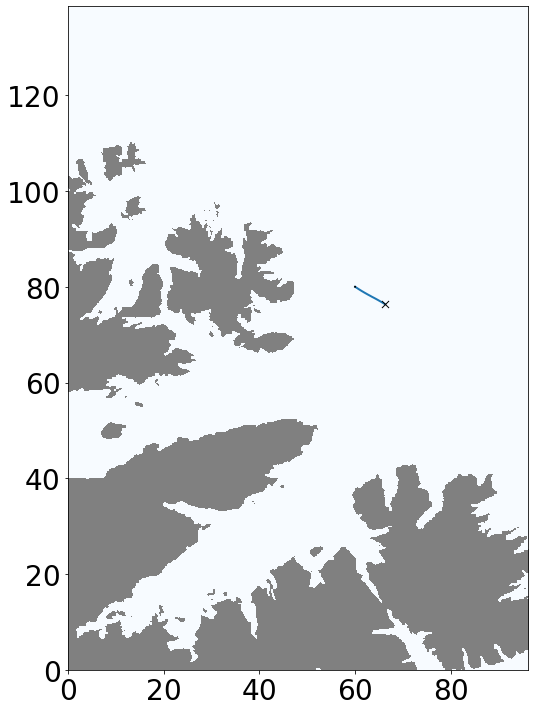

In [44]:
plot_trajectory(bt_trajectories)

## OpenDrift

In [45]:
from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
from opendrift.models.oceandrift import OceanDrift
from datetime import datetime, timedelta

import xarray as xr

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/.conda/envs/gpuocean/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-45-cd377a5cd9f6>", line 1, in <module>
    from opendrift.readers import reader_netCDF_CF_generic, reader_ROMS_native
ModuleNotFoundError: No module named 'opendrift'


ModuleNotFoundError: No module named 'opendrift'

In [ ]:
reader = reader_ROMS_native.Reader(source_url)
reader.start_time

In [ ]:
# Checking how to map (x,y) to/from (lon, lat)

#eta_rho: 801 xi_rho: 1161
lon0 = ds.lon_rho.isel(eta_rho=0, xi_rho=0).data, 
lat0 = ds.lat_rho.isel(eta_rho=0, xi_rho=0).data
print("lonlat(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader.lonlat2xy(lon0, lat0))

lonend = ds.lon_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
latend = ds.lat_rho.isel(eta_rho=801-1, xi_rho=1161-1).data
print("lonlat(-1, -1): ", (lonend, latend))
print("\tgives (x, y): ", reader.lonlat2xy(lonend, latend))


lon0u = ds.lon_u.isel(eta_u=0, xi_u=0).data, 
lat0u = ds.lat_u.isel(eta_u=0, xi_u=0).data
print("lonlatu(0, 0): ", (lon0, lat0))
print("\tgives (x, y): ", reader.lonlat2xy(lon0, lat0))

Based on the dimensions of eta_* and xi_*, it seems that eta_rho and xi_rho is from boundary to boundary. 

In [ ]:
# Translate initx, inity to initlon, initlat
init_local_index_x = np.array(initx)/160
init_local_index_y = np.array(inity)/160

init_global_index_x = init_local_index_x + x0
init_global_index_y = init_local_index_y + y0

init_lon, init_lat = reader.xy2lonlat(init_global_index_x, init_global_index_y)
print("init_lon: ", init_lon)
print("init_lat: ", init_lat)

In [ ]:
o = OceanDrift(loglevel=20)

#o.add_reader([reader_barents, reader_wind])
o.add_reader(reader)


In [ ]:
o.seed_elements(lat=init_lat, lon=init_lon, time=reader.start_time+ timedelta(hours=t), 
                wind_drift_factor=np.zeros_like(init_lat))


In [ ]:
o.run(duration = timedelta(hours=6), time_step=600, time_step_output=600)


In [ ]:
o_trajectories = Observation.Observation(domain_size_x=nx*dx, domain_size_y=ny*dy, nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [ ]:
t = o.get_time_array()[1]
for i in range(len(t)):
    t[i] = t[i].total_seconds()
t = np.array(t)

In [ ]:
lon, lat = o.get_lonlats()
x,y = reader.lonlat2xy(lon,lat)

In [ ]:
X = (x-x0)*160
Y = (y-y0)*160

In [ ]:
o_trajectories = Observation.Observation(domain_size_x=dx*nx, domain_size_y=ny*dy,
                        nx=x1-x0, ny=y1-y0, land_mask=barotropic_sim.getLandMask())

In [ ]:
o_trajectories.add_observations_from_arrays(t, X, Y)

In [ ]:
plot_trajectory(bt_trajectories, o_trajectories)

In [ ]:
nc["ocean_time"][t_stop:t_stop]

In [ ]:
[datetime.datetime.strftime(datetime.datetime.utcfromtimestamp(d), "%Y-%m-%d %H:00") for d in nc["ocean_time"][t_start:t_stop+1]]

In [ ]:
import animation_utils
animation_utils.ncAnimation(barotropic_sim.sim_writer.output_file_name, "gpuocean", comment="Barotropic")

In [ ]:
import animation_utils
anim = animation_utils.ncAnimation(source_url, "ROMS", t_range=[t_start, t_stop+1], ROMS_coord=[x0,x1,y0,y1], comment="NorFjord")
anim